In [10]:
#imports
import pandas as pd
import numpy as np
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score,mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from pickle import dump,load
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, ElasticNet


def cohen_kappa_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return cohen_kappa_score(y, y_pred)

In [11]:
##### Data #####
data = pd.read_csv(r'C:\Users\annab\OneDrive\STAT 764\Data Sets\flight_data_full.csv')
data = data.drop(['Unnamed: 0','air_time','year', 'month', 'day', 'dest', 'dep_time'],axis=1)


#data for first model
x = data.drop(['dep_delay', 'delay_severity', 'is_delayed'],axis=1)
x = pd.get_dummies(x,dtype=int)
y = data['is_delayed']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x,y,train_size=.7,random_state=764)

In [12]:
dc = DecisionTreeClassifier(class_weight='balanced')

param_grid = {
    'max_depth': [None, 2, 5, 7, 10],
    'min_samples_split': [2, 3, 5, 10, 20],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
    'ccp_alpha': [0.0, 0.1, 0.2, 0.5, 0.7, 1.0] 
}

grid_search = GridSearchCV(estimator=dc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring=cohen_kappa_scorer)

grid_search.fit(x_train1, y_train1)
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(x_test1)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'ccp_alpha': 0.0, 'max_depth': None, 'min_impurity_decrease': 0.1, 'min_samples_split': 2}


In [13]:
#Best parameters: {'ccp_alpha': 0.0, 'max_depth': None, 'min_impurity_decrease': 0.1, 'min_samples_split': 2}

rf = RandomForestClassifier(class_weight='balanced',ccp_alpha=0,max_depth=None,min_impurity_decrease=0.1,min_samples_split=2)

param_grid = {
    'n_estimators': [50, 70, 90, 100, 150, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring=cohen_kappa_scorer)

grid_search.fit(x_train1, y_train1)
best_tree = grid_search.best_estimator_
print(grid_search.best_score_)
y_pred = best_tree.predict(x_test1)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

C:\Users\annab\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\annab\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\annab\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\annab\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\annab\anaconda3\Lib\site-packages

0.45738556683933285
Best parameters: {'max_features': 'sqrt', 'n_estimators': 50}


In [14]:
#Best parameters: {'max_features': 'auto', 'n_estimators': 50}, kappa = .457

rf = RandomForestClassifier(class_weight='balanced',ccp_alpha=0,max_depth=None,min_samples_split=2,
                            max_features='sqrt',n_estimators=200)

rf.fit(x_train1, y_train1)
y_pred = rf.predict(x_test1)
print(classification_report(y_test1, y_pred))

y_pred_prob = rf.predict_proba(x_test1)[:, 1]
threshold = 0.15 #.79 both
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

print("Adjusted Threshold Classification Report:\n", classification_report(y_test1, y_pred_adjusted))


              precision    recall  f1-score   support

           0       0.88      0.99      0.93      5595
           1       0.85      0.32      0.47      1083

    accuracy                           0.88      6678
   macro avg       0.86      0.66      0.70      6678
weighted avg       0.88      0.88      0.86      6678

Adjusted Threshold Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85      5595
           1       0.40      0.79      0.53      1083

    accuracy                           0.77      6678
   macro avg       0.67      0.78      0.69      6678
weighted avg       0.86      0.77      0.80      6678



Take his y predictions 

In [15]:
y_test1

2708     0
20959    0
13384    0
19433    0
17463    0
        ..
21578    0
13491    1
9374     0
10518    0
21733    1
Name: is_delayed, Length: 6678, dtype: int64

Second Stage: Minor vs Major Delays
              precision    recall  f1-score   support

 Minor Delay       0.99      0.88      0.94      6487
 Major Delay       0.17      0.82      0.28       191

    accuracy                           0.88      6678
   macro avg       0.58      0.85      0.61      6678
weighted avg       0.97      0.88      0.92      6678



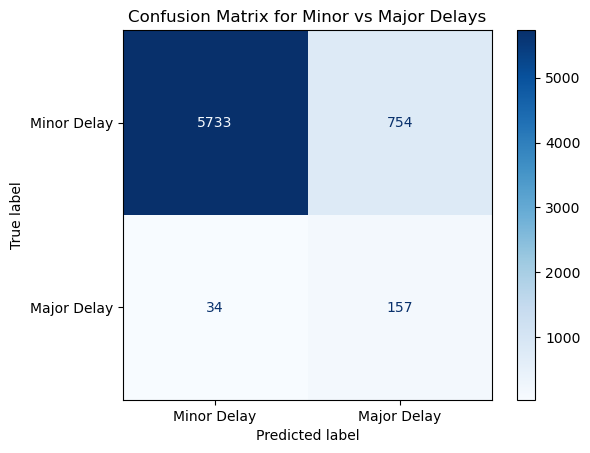

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Function to preprocess data
def preprocess_data(data):
    # Drop unnecessary columns
    data = data.drop(columns=['Unnamed: 0', 'air_time', 'year', 'month', 'day', 'dest', 'dep_time'])

    # Create target columns
    data['is_delayed'] = data['dep_delay'].apply(lambda x: 1 if x >= 30 else 0)  # On-time vs Delayed
    data['delay_severity'] = data['dep_delay'].apply(lambda x: 1 if 30 <= x <= 120 else (2 if x > 120 else None))  # Minor/Major

    # Drop dep_delay to avoid leakage
    data = data.drop(columns=['dep_delay'])

    # Fill missing values
    data = data.fillna(data.median(numeric_only=True))  # Fill numeric columns with median
    categorical_cols = ['carrier', 'origin', 'type', 'manufacturer', 'model', 'engine']
    for col in categorical_cols:
        data[col] = data[col].fillna(data[col].mode()[0])  # Fill categorical columns with mode

    return data

# Load and preprocess the dataset
data = pd.read_csv(r'C:\Users\annab\OneDrive\STAT 764\Data Sets\flight_data_full.csv')
data = preprocess_data(data)

# -----------------------------
# Second Stage: Minor vs Major Delays
# -----------------------------
# Use only delayed flights predicted by the first stage
delayed_indices = (y_pred == 1)  # Flights predicted as delayed
X_test_delayed = X_test[delayed_indices]  # Features of delayed flights
y_test_delayed_actual = data.iloc[X_test_delayed.index]['delay_severity']  # True delay severity

# Prepare second stage training data
data_delayed = data[data['delay_severity'].notna()]  # Keep only delayed flights
X_delayed_full = pd.concat(
    [pd.DataFrame(scaler.transform(data_delayed[numerical_cols]), columns=numerical_cols),
     pd.DataFrame(encoder.transform(data_delayed[categorical_cols]).toarray(), columns=encoded_cat_cols)], axis=1
)
y_delayed = data_delayed['delay_severity']  # Minor (1) or Major (2)

# Split delayed data into training and testing sets for the second stage
X_train_delayed, X_test_delayed, y_train_delayed, y_test_delayed = train_test_split(
    X_delayed_full, y_delayed, test_size=0.3, random_state=42
)

# Train Decision Tree Classifier for the second stage
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced')
dt_model.fit(X_train_delayed, y_train_delayed)

# Predict and evaluate for delayed flights
y_pred_dt = dt_model.predict(X_test_delayed)

print("Second Stage: Minor vs Major Delays")
print(classification_report(y_test_delayed, y_pred_dt, target_names=['Minor Delay', 'Major Delay']))

# Plot confusion matrix for the second stage
ConfusionMatrixDisplay.from_estimator(dt_model, X_test_delayed, y_test_delayed,
                                       display_labels=['Minor Delay', 'Major Delay'], cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Minor vs Major Delays")
plt.show()